<a href="https://colab.research.google.com/github/mycegcpdemo/transfer-learning/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The setup
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms



# Install summary from torchinfo
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

[INFO] Couldn't find torchinfo... installing it.


'cuda'

In [ ]:
# Get the data we will be working with

import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
import random

random.seed(42)
train_dir = image_path / "train"
test_dir = image_path / "test"

print (train_dir)
print (test_dir)
print(random.choice(os.listdir(train_dir)))
print(random.choice(os.listdir(test_dir)))

data/pizza_steak_sushi/train
data/pizza_steak_sushi/test
pizza
steak


In [ ]:
# When using transfer learning we can extract the transforms from the weights of the trained model

#weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT
print(weights)

auto_transforms = weights.transforms()
print(auto_transforms)

EfficientNet_V2_L_Weights.IMAGENET1K_V1
ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)


In [ ]:
# Create datasets from the train and test data
from torch.utils.data import DataLoader

train_dataset = torchvision.datasets.ImageFolder(
    root = train_dir,
    transform = auto_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    root = test_dir,
    transform = auto_transforms
)


# Create dataloaders for train and test data

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

# Do not usually have to shuffle test data
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False, #dont shuffle test data because you want consistent test performance
                             num_workers=NUM_WORKERS)


print(type(train_dataloader))
print(type(test_dataloader))
# Get class names from dataloader
class_names = train_dataset.classes
print(class_names)

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
['pizza', 'steak', 'sushi']


In [ ]:
# Get the model and move it to the device
model = torchvision.models.efficientnet_v2_l(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:06<00:00, 76.8MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Use model summary to get more info
summary(model,
        input_size=(32, 3, 33, 33),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 33, 33]      [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 33, 33]      [32, 1280, 2, 2]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 33, 33]      [32, 32, 17, 17]     --                   True
│    │    └─Conv2d (0)                                       [32, 3, 33, 33]      [32, 32, 17, 17]     864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 17, 17]     [32, 32, 17, 17]     64                   True
│    │    └─SiLU (2)                                         [32, 32, 17, 17]     [32, 32, 17, 17]     --                   --
│    └─Sequential (1)                                        [32, 32, 17, 17]     [32, 32, 17,

In [ ]:
# The output from printing model will show you the classifer layer and from there you can change their
# Linear output to the number of features you desire, in out case that is three.   This is called freezing the base layers
# (features section of the model) and changing the output layer to suit our needs

# HOW DO WE DO THIS?
# FIRST: By setting the "requires_grad=False", PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

for param in model.features.parameters():
    param.requires_grad = False

#SECOND: By changing the classifier layer from 1000 output to our output len(class_names) = 3 and ensuring our new classifier layer is on the same device as our model

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the lenght of class)names
output_shape = len(class_names)

# Keep everything the same except for the out_features shape
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.4, inplace=True),
    torch.nn.Linear(
        in_features=1280,
        out_features=output_shape,
        bias=True
    )
).to(device)

In [ ]:
# Summary of our updated model
print("Summary of our updated model \n\n")

summary(model,
        input_size=(32, 3, 33, 33),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

#Check to see if the features layers are all trainable=false and the classifier layer is trainable=true
#print("\n Check to see if the features layers are all trainable=false and the classifier layer is trainable=true \n")


Summary of our updated model 




Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 33, 33]      [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 33, 33]      [32, 1280, 2, 2]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 33, 33]      [32, 32, 17, 17]     --                   False
│    │    └─Conv2d (0)                                       [32, 3, 33, 33]      [32, 32, 17, 17]     (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 17, 17]     [32, 32, 17, 17]     (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 17, 17]     [32, 32, 17, 17]     --                   --
│    └─Sequential (1)                                        [32, 32, 17, 17]     [32, 

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
#Single call to combine Train and Test steps


from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0648 | train_acc: 0.3438 | test_loss: 0.9876 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.9591 | train_acc: 0.5195 | test_loss: 0.6857 | test_acc: 0.8968
Epoch: 3 | train_loss: 0.7672 | train_acc: 0.6445 | test_loss: 0.6637 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.6717 | train_acc: 0.7383 | test_loss: 0.5918 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.5952 | train_acc: 0.7773 | test_loss: 0.5470 | test_acc: 0.9072
Total training time: 90.383 seconds


In [ ]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

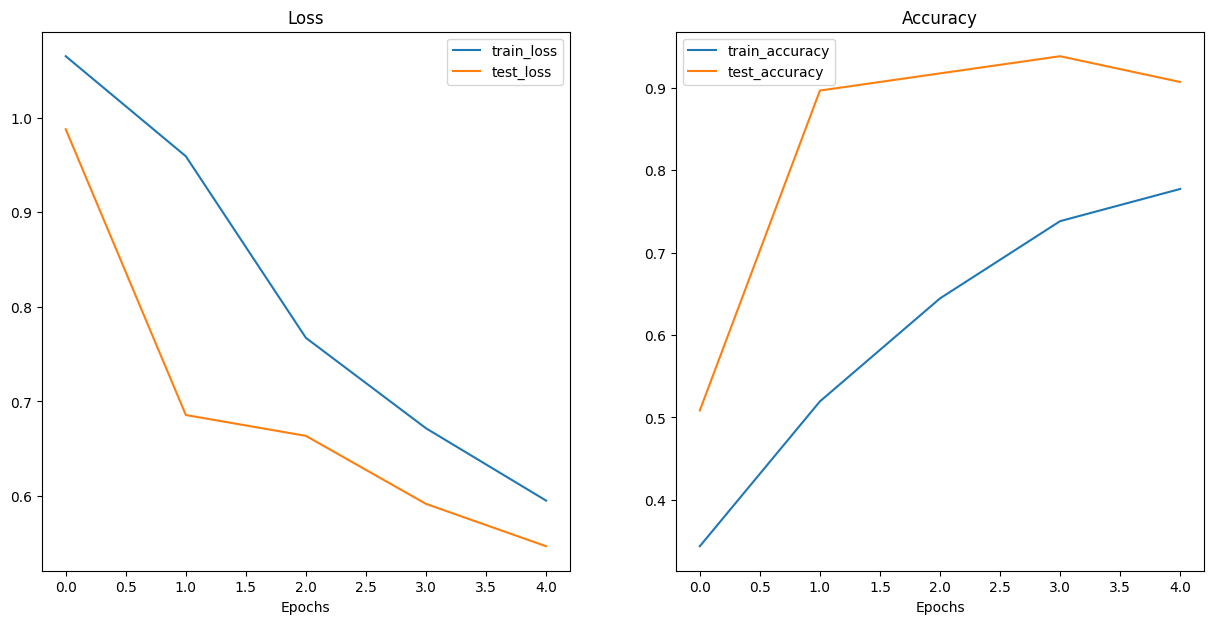

In [ ]:
plot_loss_curves(model_results)